In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Perceptron
%matplotlib inline

In [2]:
df_train = pd.read_csv('./hw5_data_train.csv')
df_train.fillna('', inplace=True)
print('positive samples: {}'.format(np.sum(df_train['Recommended'] == 1)))
print('negative samples: {}'.format(np.sum(df_train['Recommended'] == 0)))
df_train.head()

positive samples: 14485
negative samples: 3129


,Title,Review,Recommended
0,Beautiful unique dress,Wore this to my sons wedding. found it last mi...,1
1,Had high hopes but...,"Gals, if you absolutely must have this top wai...",0
2,Buttons -buttons so cute!,I hardly believe i have not reviewed htis yet....,1
3,Love this dress,This dress is so cute and comfortable. i'm nor...,1
4,Perfect summer pants!,The linen- cotton blend breathes so well for a...,1


In [3]:
df_test = pd.read_csv('./hw5_data_test.csv')
df_test.fillna('', inplace=True)
df_test.head()

,Title,Review,Recommended
0,,,0
1,Perfect pair!!,This pair of age stevie capris is everything t...,1
2,Talk about creature comforts!,This is a beautifully designed jacket that eve...,1
3,,,1
4,So comfotable,I ordered this dress in 0p since i am 5ft. it ...,1


In [4]:
def visualize_feature(model, feature_names, visual, title):
    # extract the 20 most important features
    number = 10
    neg_feature = feature_names[np.argsort(model.coef_)[0][: number]]
    neg_value = np.sort(model.coef_)[0][: number]
    pos_feature = feature_names[np.argsort(model.coef_)[0][-number:]]
    pos_value = np.sort(model.coef_)[0][-number:]
    print('import features:')
    print('negative: {}'.format(np.sort(neg_feature)))
    print('positive: {}'.format(np.sort(pos_feature)))
    
    if visual:
        # visualize the 20 most important features
        plt.figure(figsize=(16, 5))
        plt.bar(range(-number, 0), neg_value)
        plt.bar(range(number), pos_value)
        r = plt.xticks(range(-number, number), np.concatenate((neg_feature, pos_feature)), rotation=45, size=15, ha='right')
        plt.title(title)

In [5]:
def before_tuning(pipeline, X_train, y_train, visual=True):
    print('Use CountVectorizer with the default settings and train a linear classifier......')
    scores = cross_validate(pipeline, X_train, y_train, return_train_score=True, scoring='roc_auc')
    print('mean roc_auc train score: {:.3f}\nmean roc_auc val score: {:.3f}'.format(
        np.mean(scores['train_score']), np.mean(scores['test_score'])))

    pipeline.fit(X_train, y_train)
    feature_names = np.array(pipeline.steps[0][1].get_feature_names())
    visualize_feature(pipeline.steps[-1][1], feature_names, visual, 'before tuning the regularization parameter')
    return pipeline

In [58]:
def after_tuning(pipeline, param_grid, X_train, y_train, visual=True):
    print('Tune the regularization parameter of the classifier......')
    grid = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=8, return_train_score=True).fit(X_train, y_train)
    print('best mean roc_auc train score: {:.3f}\nbest mean roc_auc val score: {:.3f}'.format(
        grid.cv_results_['mean_train_score'][grid.best_index_], grid.best_score_))
    print('regularization parameter: {}'.format(grid.best_params_))

    best = grid.best_estimator_
    feature_names = np.array(best.steps[0][1].get_feature_names())
    visualize_feature(best.steps[-1][1], feature_names, visual, 'after tuning the regularization parameter')
    return best

In [8]:
def compare_features(pipeline1, name1, pipeline2, name2, number=10):
    print('import features of {}:'.format(name1))
    feature_names_1 = np.array(pipeline1.steps[0][1].get_feature_names())
    neg_feature_1 = feature_names_1[np.argsort(pipeline1.steps[-1][1].coef_)[0][: number]]
    pos_feature_1 = feature_names_1[np.argsort(pipeline1.steps[-1][1].coef_)[0][-number:]]
    print('negative: {}'.format(np.sort(neg_feature_1)))
    print('positive: {}'.format(np.sort(pos_feature_1)))
    print('feature size: {}'.format(len(feature_names_1)))

    print('\nimport features of {}:'.format(name2))
    feature_names_2 = np.array(pipeline2.steps[0][1].get_feature_names())
    neg_feature_2 = feature_names_2[np.argsort(pipeline2.steps[-1][1].coef_)[0][: number]]
    pos_feature_2 = feature_names_2[np.argsort(pipeline2.steps[-1][1].coef_)[0][-number:]]
    print('negative: {}'.format(np.sort(neg_feature_2)))
    print('positive: {}'.format(np.sort(pos_feature_2)))
    print('feature size: {}'.format(len(feature_names_2)))

In [29]:
def test_score(pipeline):
    X_test = pipeline.steps[0][1].transform(df_test['Title'] + ' ' + df_test['Review'])
    y_test = df_test['Recommended']
    print('roc_auc test score: {:.3f}'.format(roc_auc_score(y_test, pipeline.steps[-1][1].predict_proba(X_test)[:, 1])))

## Task 1 Title and Body

### Task 1.1 Use the title only

Use CountVectorizer with the default settings and train a linear classifier......
mean roc_auc train score: 0.935
mean roc_auc val score: 0.887
import features:
negative: ['cheap' 'disappointed' 'disappointing' 'disappointment' 'horrible' 'meh'
 'poor' 'terrible' 'unflattering' 'wanted']
positive: ['amazing' 'comfortable' 'fun' 'gorgeous' 'little' 'love' 'perfect'
 'stunning' 'unique' 'versatile']


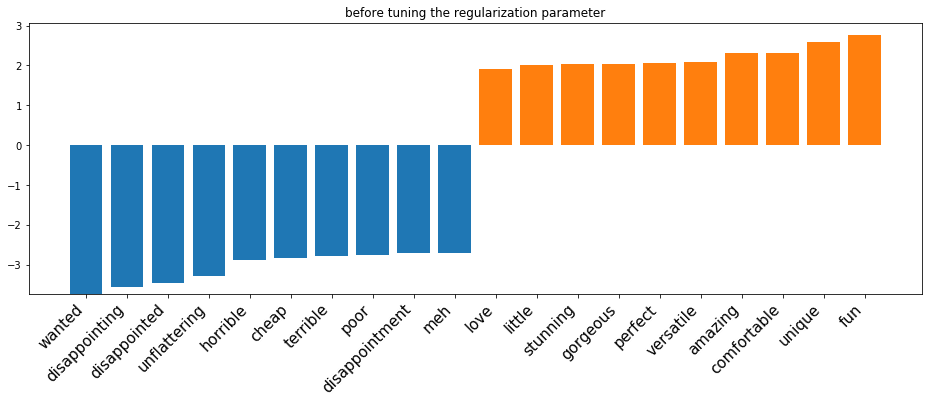

In [22]:
pipeline_1 = make_pipeline(CountVectorizer(), LogisticRegression())
X_train = df_train['Title']
y_train = df_train['Recommended']
pipeline_1 = before_tuning(pipeline_1, X_train, y_train)

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.932
best mean roc_auc val score: 0.886
regularization parameter: {'logisticregression__C': 0.8051909287205262}
import features:
negative: ['cheap' 'disappointed' 'disappointing' 'horrible' 'meh' 'not' 'poor'
 'terrible' 'unflattering' 'wanted']
positive: ['amazing' 'comfortable' 'fun' 'gorgeous' 'little' 'love' 'perfect'
 'stunning' 'unique' 'versatile']
6.018839597702026


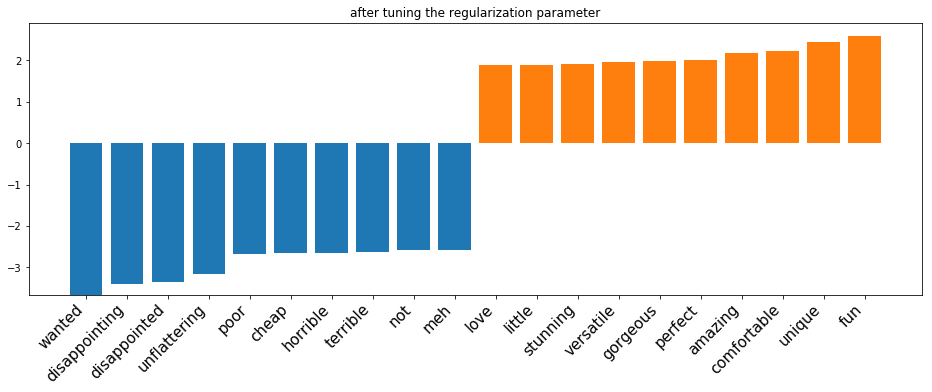

In [25]:
param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline_cv1 = make_pipeline(CountVectorizer(), LogisticRegression(), memory='cache_folder')
pipeline_cv1 = after_tuning(pipeline_cv1, param_grid, X_train, y_train)

### Task 1.2 Use the review body only

Use CountVectorizer with the default settings and train a linear classifier......
mean roc_auc train score: 0.992
mean roc_auc val score: 0.908
import features:
negative: ['awful' 'cheap' 'hopes' 'horrible' 'poor' 'returned' 'shame' 'shrank'
 'space' 'weirdly']
positive: ['adore' 'elegant' 'justice' 'keeper' 'midweight' 'pleased' 'season'
 'sold' 'stylish' 'unique']


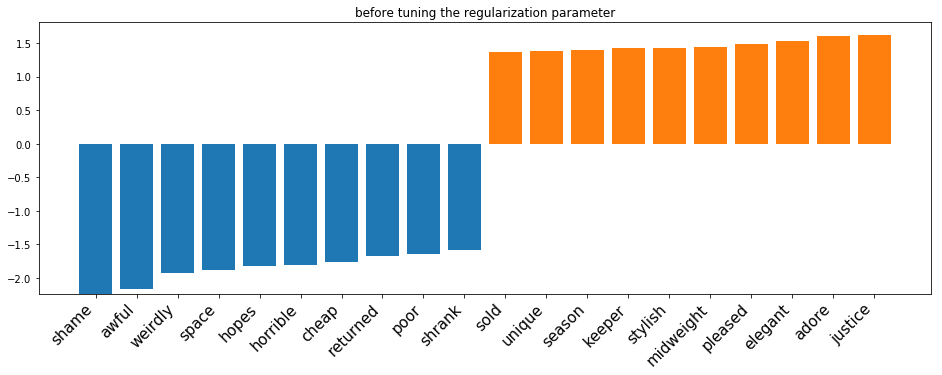

In [17]:
pipeline_2 = make_pipeline(CountVectorizer(), LogisticRegression())
X_train = df_train['Review']
y_train = df_train['Recommended']
pipeline_2 = before_tuning(pipeline_2, X_train, y_train)

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.961
best mean roc_auc val score: 0.920
regularization parameter: {'logisticregression__C': 0.06458210704924264}
import features:
negative: ['awful' 'cheap' 'disappointed' 'huge' 'poor' 'returned' 'returning'
 'shame' 'unflattering' 'wanted']
positive: ['comfortable' 'compliments' 'easy' 'feminine' 'happy' 'little' 'love'
 'perfect' 'perfectly' 'unique']


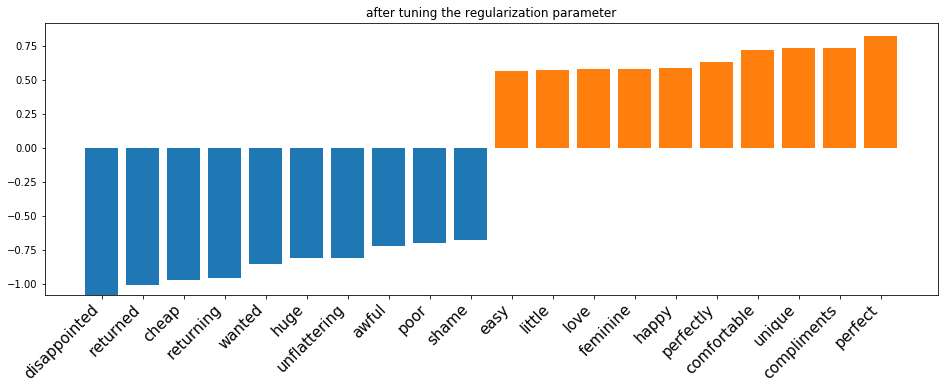

In [18]:
param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline_cv2 = make_pipeline(CountVectorizer(), LogisticRegression(), memory='cache_folder')
pipeline_cv2 = after_tuning(pipeline_cv2, param_grid, X_train, y_train)

### Task 1.3 Concatenate the title and review to a single text and analyze that

Use CountVectorizer with the default settings and train a linear classifier......
mean roc_auc train score: 0.994
mean roc_auc val score: 0.927
import features:
negative: ['awful' 'disappointed' 'eh' 'hopes' 'horrible' 'meh' 'returned' 'shame'
 'shrank' 'weirdly']
positive: ['adore' 'caution' 'drop' 'elegant' 'keeper' 'midweight' 'mock' 'pleased'
 'stylish' 'unique']


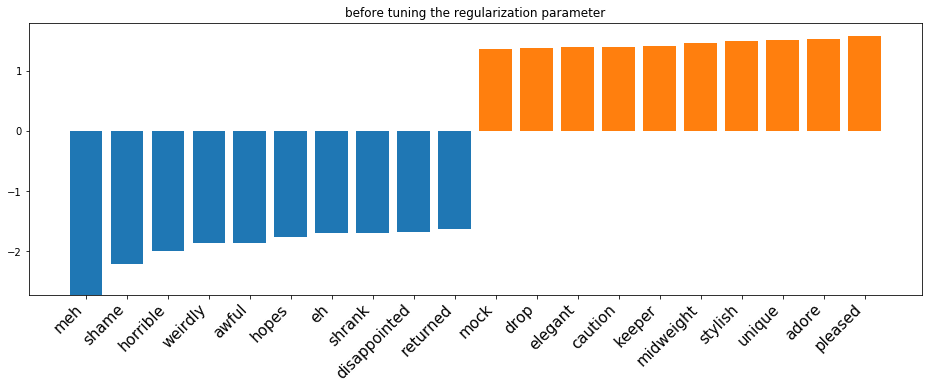

In [11]:
pipeline_3 = make_pipeline(CountVectorizer(), LogisticRegression())
X_train = df_train['Title'] + ' ' + df_train['Review']
y_train = df_train['Recommended']
pipeline_3 = before_tuning(pipeline_3, X_train, y_train)

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.974
best mean roc_auc val score: 0.937
regularization parameter: {'logisticregression__C': 0.08912715168808354}
import features:
negative: ['cheap' 'disappointed' 'disappointing' 'huge' 'meh' 'poor' 'returned'
 'returning' 'unflattering' 'wanted']
positive: ['amazing' 'beautifully' 'comfortable' 'compliments' 'easy' 'love'
 'perfect' 'perfectly' 'sold' 'unique']


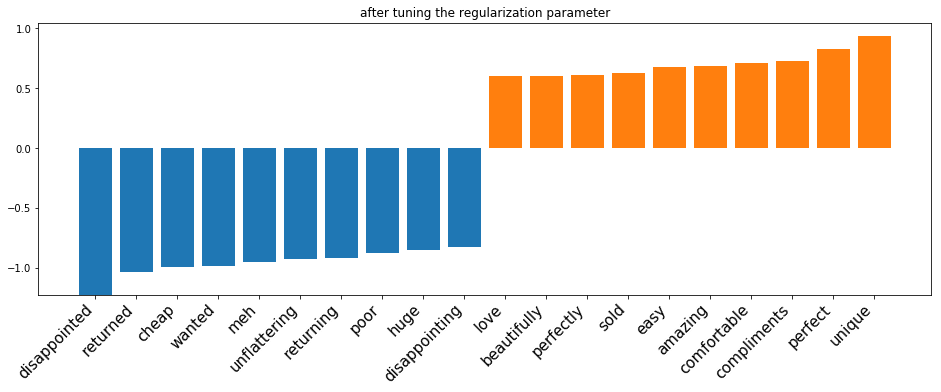

In [12]:
param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline_cv3 = make_pipeline(CountVectorizer(), LogisticRegression(), memory='cache_folder')
pipeline_cv3 = after_tuning(pipeline_cv3, param_grid, X_train, y_train)

### Task 1.4 Vectorizing title and review individually and concatenating the vector representations

In [194]:
# vectorize title
vect_title = CountVectorizer()
X_train_title = vect_title.fit_transform(df_train['Title'])
feature_names_title = np.array(vect_title.get_feature_names())

# vectorize review
vect_review = CountVectorizer()
X_train_review = vect_review.fit_transform(df_train['Review'])
feature_names_review = np.array(vect_review.get_feature_names())

# concatenate the vector representations
X_train = hstack([X_train_title, X_train_review])
y_train = df_train['Recommended']
feature_names_4 = np.concatenate((feature_names_title, feature_names_review))

Use CountVectorizer with the default settings and train a linear classifier......
mean roc_auc train score: 0.996
mean roc_auc val score: 0.930


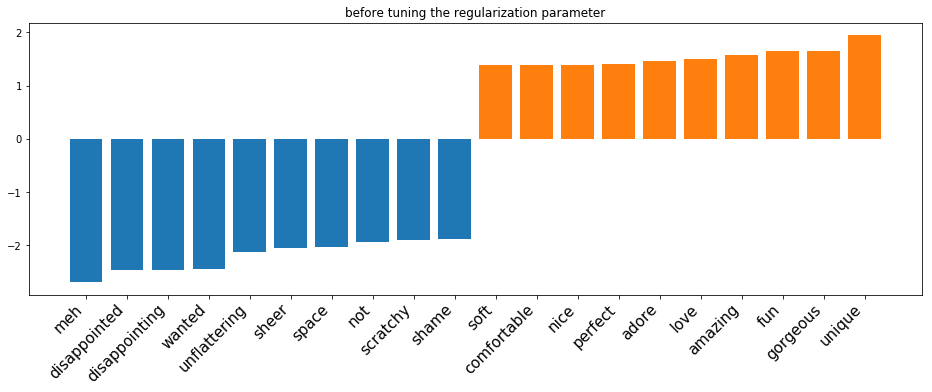

In [195]:
lr_4 = before_tuning(X_train, y_train, feature_names_4)

Tune the regularization parameter of the classifier......
roc_auc val score: 0.937
regularization parameter: 0.14956479844211598


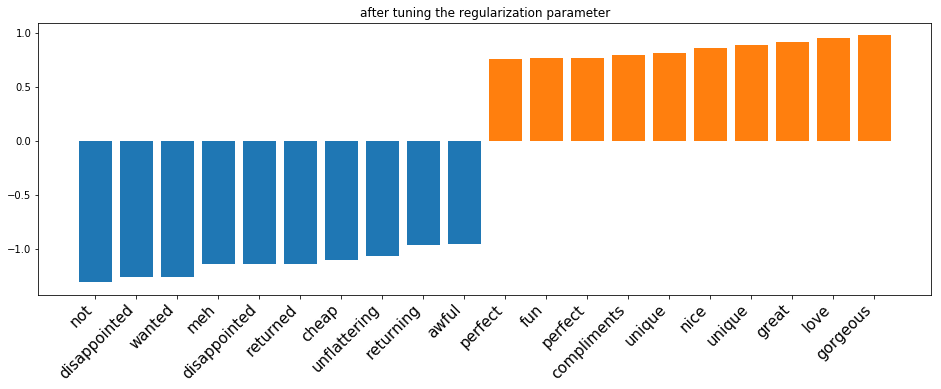

In [196]:
lrCV_4 = after_tuning(X_train, y_train, feature_names_4)

### Which one works best?

#### Answer: 

The third and fourth methods have better performance after tuning regularization parameter of the classifier.

In [26]:
test_score(pipeline_cv3)

roc_auc test score: 0.934


# Task 2 Feature Tuning

In [21]:
X_train = df_train['Title'] + ' ' + df_train['Review']
y_train = df_train['Recommended']

### 2.1 Try using TfidfVectorizer instead of CountVectorizer. Does it change the score? Does it change the important coefficients?

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.976
best mean roc_auc val score: 0.946
regularization parameter: {'logisticregression__C': 1.8190500101136677}
import features:
negative: ['cheap' 'disappointed' 'disappointing' 'huge' 'not' 'poor' 'returned'
 'returning' 'unflattering' 'wanted']
positive: ['comfortable' 'compliments' 'gorgeous' 'great' 'little' 'love' 'perfect'
 'soft' 'unique' 'with']
41.17573118209839


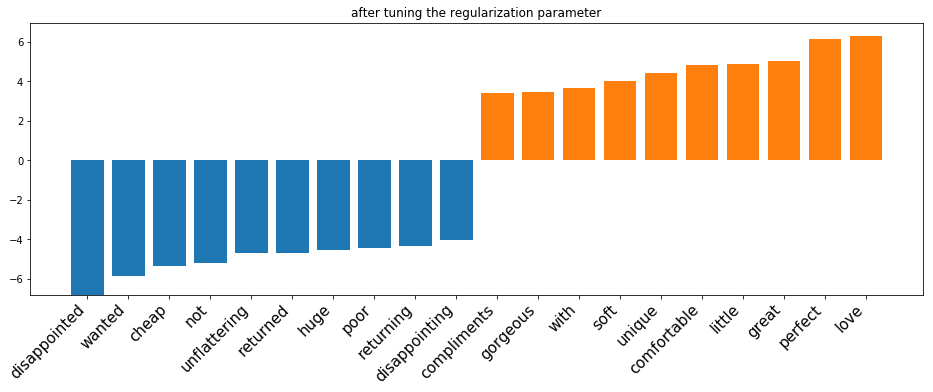

In [43]:
param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline_tfidf = make_pipeline(TfidfVectorizer(), LogisticRegression(), memory='cache_folder')
pipeline_tfidf = after_tuning(pipeline_tfidf, param_grid, X_train, y_train)

In [16]:
compare_features(pipeline_cv3, 'best model in Task 1', pipeline_tfidf, 'TfidfVectorizer')

import features of best model in Task 1:
negative: ['cheap' 'disappointed' 'disappointing' 'huge' 'meh' 'poor' 'returned'
 'returning' 'unflattering' 'wanted']
positive: ['amazing' 'beautifully' 'comfortable' 'compliments' 'easy' 'love'
 'perfect' 'perfectly' 'sold' 'unique']
feature size: 13010

import features of TfidfVectorizer:
negative: ['cheap' 'disappointed' 'huge' 'not' 'poor' 'returned' 'returning'
 'unflattering' 'wanted' 'was']
positive: ['comfortable' 'compliments' 'gorgeous' 'great' 'little' 'love' 'perfect'
 'soft' 'unique' 'with']
feature size: 13010


The score increases after using TfidfVectorizer instead of CountVectorizer.

The important features don't change too much. There are many features appearing in both models.

### 2.2 Remember that TfidfVectorizer uses normalization by default. Does using a Normalizer with CountVectorizer change the outcome?

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.976
best mean roc_auc val score: 0.943
regularization parameter: {'logisticregression__C': 9.928191318135308}
import features:
negative: ['cheap' 'disappointed' 'disappointing' 'meh' 'poor' 'returned'
 'returning' 'shame' 'unflattering' 'wanted']
positive: ['amazing' 'beautifully' 'comfortable' 'compliments' 'easy' 'gorgeous'
 'perfect' 'perfectly' 'sold' 'unique']


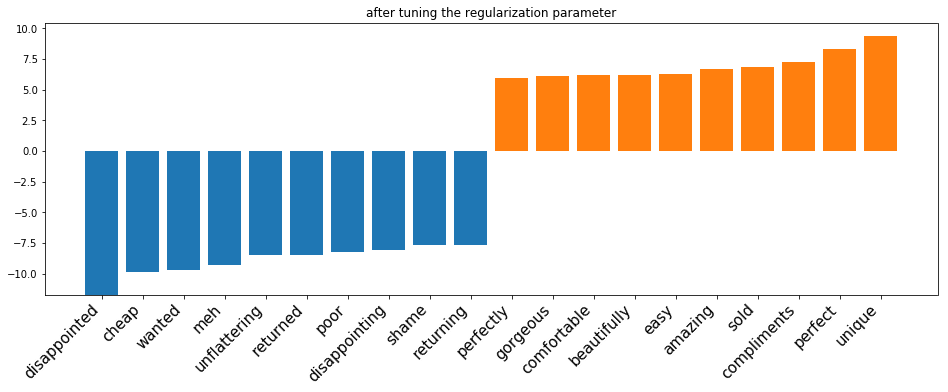

In [14]:
param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline_normal = make_pipeline(CountVectorizer(), Normalizer(), LogisticRegression(), memory='cache_folder')
pipeline_normal = after_tuning(pipeline_normal, param_grid, X_train, y_train)

In [17]:
compare_features(pipeline_tfidf, 'TfidfVectorizer', pipeline_normal, 'using a Normalizer with CountVectorizer')

import features of TfidfVectorizer:
negative: ['cheap' 'disappointed' 'huge' 'not' 'poor' 'returned' 'returning'
 'unflattering' 'wanted' 'was']
positive: ['comfortable' 'compliments' 'gorgeous' 'great' 'little' 'love' 'perfect'
 'soft' 'unique' 'with']
feature size: 13010

import features of using a Normalizer with CountVectorizer:
negative: ['cheap' 'disappointed' 'disappointing' 'meh' 'poor' 'returned'
 'returning' 'shame' 'unflattering' 'wanted']
positive: ['amazing' 'beautifully' 'comfortable' 'compliments' 'easy' 'gorgeous'
 'perfect' 'perfectly' 'sold' 'unique']
feature size: 13010


Using a Normalizer with CountVectorizer doesn't change the outcome too much. The score is a little worse than using TfidfVectorizer. The important features of these two models are almost the same.

### 2.3 Try using stop-word. Do the standard English stop-words help? Why / why not?

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.976
best mean roc_auc val score: 0.937
regularization parameter: {'logisticregression__C': 1.858997151617077}
import features:
negative: ['cheap' 'disappointed' 'disappointing' 'huge' 'meh' 'poor' 'returned'
 'returning' 'unflattering' 'wanted']
positive: ['comfortable' 'compliments' 'fits' 'gorgeous' 'great' 'little' 'love'
 'perfect' 'soft' 'unique']


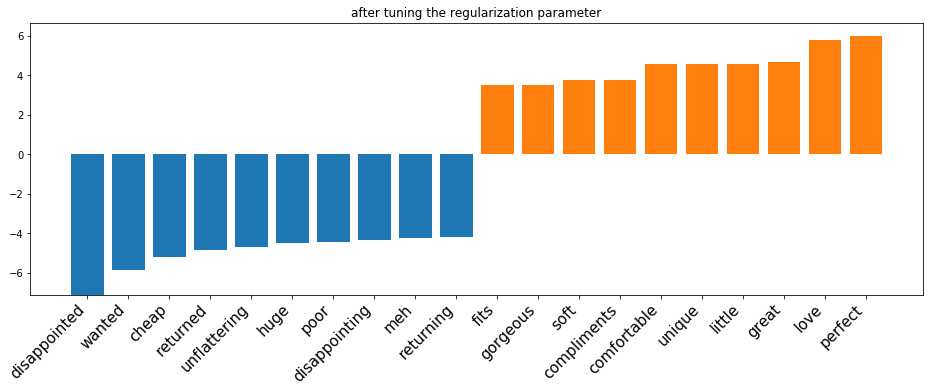

In [19]:
param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline_stopword = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression(), memory='cache_folder')
pipeline_stopword = after_tuning(pipeline_stopword, param_grid, X_train, y_train)

In [20]:
compare_features(pipeline_tfidf, 'TfidfVectorizer', pipeline_stopword, 'using TfidfVectorizer with stop-word')

import features of TfidfVectorizer:
negative: ['cheap' 'disappointed' 'huge' 'not' 'poor' 'returned' 'returning'
 'unflattering' 'wanted' 'was']
positive: ['comfortable' 'compliments' 'gorgeous' 'great' 'little' 'love' 'perfect'
 'soft' 'unique' 'with']
feature size: 13010

import features of using TfidfVectorizer with stop-word:
negative: ['cheap' 'disappointed' 'disappointing' 'huge' 'meh' 'poor' 'returned'
 'returning' 'unflattering' 'wanted']
positive: ['comfortable' 'compliments' 'fits' 'gorgeous' 'great' 'little' 'love'
 'perfect' 'soft' 'unique']
feature size: 12727


Using the standard English stop-words doesn't help. It's worse than the TfidfVectorizer without stop-words.

### 2.4 Limit the vocabulary using min_df or max_df. How to these impact the number of features, and how do they impact the scores?

In [34]:
pipeline_tfidf_min_dfs = []
for min_df in range(2, 6):
    param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
    pipeline = make_pipeline(TfidfVectorizer(min_df=min_df), LogisticRegression(), memory='cache_folder')
    pipeline = after_tuning(pipeline, param_grid, X_train, y_train, visual=False)
    pipeline_tfidf_min_dfs.append(pipeline)
    feature_names = np.array(pipeline.steps[0][1].get_feature_names())
    print('min_df: {}, shape: {}'.format(min_df, len(feature_names)))
    print('-'*80)

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.978
best mean roc_auc val score: 0.946
regularization parameter: {'logisticregression__C': 2.312204691327636}
import features:
negative: ['cheap' 'disappointed' 'huge' 'meh' 'not' 'poor' 'returned' 'returning'
 'unflattering' 'wanted']
positive: ['comfortable' 'compliments' 'gorgeous' 'great' 'little' 'love' 'perfect'
 'soft' 'unique' 'with']
min_df: 2, shape: 7477
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.975
best mean roc_auc val score: 0.946
regularization parameter: {'logisticregression__C': 1.7880998948527007}
import features:
negative: ['cheap' 'disappointed' 'huge' 'meh' 'not' 'poor' 'returned' 'returning'
 'unflattering' 'wanted']
positive: ['comfortable' 'compliments' 'great' 'little' 'love' 'nice' 'perfect'
 'soft' 'unique' 'with']
min_df: 3, shape: 5848
----

The number of features decreases with the increase of min_df. The scores of using different min_df are almost the same. 

However, only using min_df is still worse than TfidfVectorizer.

In [30]:
test_score(pipeline_tfidf_min_dfs[0])

roc_auc test score: 0.942


# Task 3 n-grams

### 3.1 Using your current best model, try changing from unigrams to n-grams of varying length. What provides the best performance? Visualize the coefficients. Try visualizing only the higher-order n-grams that are important.

In [35]:
pipeline_tfidf_ngram_ranges = []
ngram_ranges = [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
for ngram_range in ngram_ranges:
    param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
    pipeline = make_pipeline(TfidfVectorizer(min_df=2, ngram_range=ngram_range), 
                                               LogisticRegression(), memory='cache_folder')
    pipeline = after_tuning(pipeline, param_grid, X_train, y_train, visual=False)
    pipeline_tfidf_ngram_ranges.append(pipeline)
    feature_names = np.array(pipeline.steps[0][1].get_feature_names())
    print('ngram_range: {}, shape: {}'.format(ngram_range, len(feature_names)))
    print('-'*80)

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.977
best mean roc_auc val score: 0.946
regularization parameter: {'logisticregression__C': 2.0920596344295737}
import features:
negative: ['cheap' 'disappointed' 'huge' 'meh' 'not' 'poor' 'returned' 'returning'
 'unflattering' 'wanted']
positive: ['comfortable' 'compliments' 'gorgeous' 'great' 'little' 'love' 'perfect'
 'soft' 'unique' 'with']
ngram_range: (1, 1), shape: 7477
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.997
best mean roc_auc val score: 0.952
regularization parameter: {'logisticregression__C': 5.553912408456737}
import features:
negative: ['cheap' 'disappointed' 'huge' 'not' 'not flattering' 'poor' 'returned'
 'to love' 'unflattering' 'was']
positive: ['comfortable' 'great' 'little' 'love' 'love this' 'not too' 'perfect'
 'soft' 'unique' 'with']
ngram_rang

import features:
negative: ['cheap' 'disappointed' 'huge' 'not' 'not flattering' 'poor' 'returned'
 'to love' 'unflattering' 'was']
positive: ['comfortable' 'great' 'little' 'love' 'love this' 'not too' 'perfect'
 'soft' 'unique' 'with']


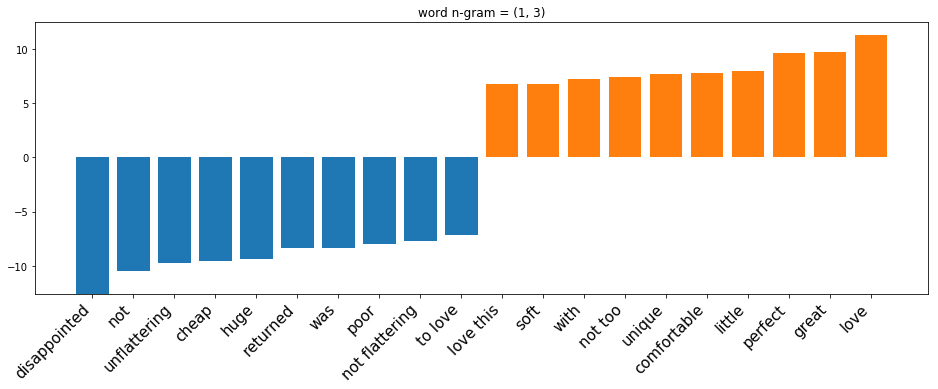

In [37]:
feature_names = np.array(pipeline_tfidf_ngram_ranges[2].steps[0][1].get_feature_names())
visualize_feature(pipeline_tfidf_ngram_ranges[2].steps[-1][1], feature_names, True, 'word n-gram = (1, 3)')

### 3.2 Try using character n-grams. Visualize the coefficients. Can we learn something from this?

In [41]:
pipeline_tfidf_char_ngram_ranges = []
ngram_ranges = [(j, i) for i in range(2, 6) for j in range(2, i + 1)]
for ngram_range in ngram_ranges:
    param_grid = {'logisticregression__C': 10 ** (np.random.rand(10) * 4 - 2)}
    pipeline = make_pipeline(TfidfVectorizer(min_df=2, ngram_range=ngram_range, analyzer="char_wb"), 
                                               LogisticRegression(), memory='cache_folder')
    pipeline = after_tuning(pipeline, param_grid, X_train, y_train, visual=False)
    pipeline_tfidf_char_ngram_ranges.append(pipeline)
    feature_names = np.array(pipeline.steps[0][1].get_feature_names())
    print('ngram_range: {}, shape: {}'.format(ngram_range, len(feature_names)))
    print('-'*80)

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.941
best mean roc_auc val score: 0.917
regularization parameter: {'logisticregression__C': 3.517237092712029}
import features:
negative: ['ap' 'gn' 'hu' 'nf' 'no' 'oi' 'po' 'rn' 'wa' 'wf']
positive: ['! ' 'gr' 'i ' 'iq' 'mf' 'ov' 'rf' 'tl' 'ts' 'ys']
ngram_range: (2, 2), shape: 1573
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.975
best mean roc_auc val score: 0.940
regularization parameter: {'logisticregression__C': 4.999306755903621}
import features:
negative: [' no' 'eap' 'ete' 'etu' 'hea' 'nfl' 'oor' 'sac' 'uge' 'unf']
positive: ['! ' 'bit' 'erf' 'lig' 'lov' 'niq' 'oft' 'rf' 'ts.' 'un ']
ngram_range: (2, 3), shape: 10993
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......
best mean r

/root/assignment2/.env/lib/python3.5/site-packages/sklearn/pipeline.py:213: UserWarning: Persisting input arguments took 0.70s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


best mean roc_auc train score: 0.976
best mean roc_auc val score: 0.945
regularization parameter: {'logisticregression__C': 2.1367727290167995}
import features:
negative: [' no' ' not' ' unf' 'ante' 'not' 'not ' 'nted' 'poor' 'unf' 'was']
positive: [' i ' ' lov' ' so' 'can ' 'erf' 'lov' 'love' 'ove' 'ove ' 't! ']
ngram_range: (3, 4), shape: 32595
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.973
best mean roc_auc val score: 0.946
regularization parameter: {'logisticregression__C': 1.27984466535987}
import features:
negative: [' not' ' unf' ' was' 'heap' 'huge' 'not ' 'nted' 'poor' 'ted ' 'was ']
positive: [' gre' ' i ' ' lov' ' nic' 'erfe' 'love' 'nice' 'ove ' 'perf' 'rfec']
ngram_range: (4, 4), shape: 23229
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......
best mean roc_auc

/root/assignment2/.env/lib/python3.5/site-packages/sklearn/pipeline.py:213: UserWarning: Persisting input arguments took 2.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


best mean roc_auc train score: 0.986
best mean roc_auc val score: 0.945
regularization parameter: {'logisticregression__C': 4.370398724518406}
import features:
negative: [' meh' ' no' ' not' ' not ' ' poor' 'not' 'not ' 'oor' 'poor' 'tent']
positive: [' ca' ' i ' ' lov' ' love' ' so' 'lov' 'love' 'love ' 'ove ' 't! ']
ngram_range: (3, 5), shape: 64993
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......


/root/assignment2/.env/lib/python3.5/site-packages/sklearn/pipeline.py:213: UserWarning: Persisting input arguments took 1.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/root/assignment2/.env/lib/python3.5/site-packages/sklearn/pipeline.py:213: UserWarning: Persisting input arguments took 1.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


best mean roc_auc train score: 0.978
best mean roc_auc val score: 0.946
regularization parameter: {'logisticregression__C': 1.718731655170264}
import features:
negative: [' huge' ' not' ' not ' ' poor' ' was' ' was ' 'huge' 'not ' 'ted ' 'was ']
positive: [' gre' ' i ' ' lov' ' love' ' nice' ' sof' ' soft' 'love' 'love ' 'ove ']
ngram_range: (4, 5), shape: 55627
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.980
best mean roc_auc val score: 0.946
regularization parameter: {'logisticregression__C': 1.8430784224241195}
import features:
negative: [' chea' ' huge' ' not ' ' poor' ' retu' ' was ' ' way ' 'anted' 'cheap'
 'wante']
positive: [' can ' ' grea' ' i ' ' love' ' nice' ' perf' ' soft' 'great' 'love '
 'perfe']
ngram_range: (5, 5), shape: 32761
--------------------------------------------------------------------------------


import features:
negative: [' no' ' not' ' not ' ' poor' 'no' 'not ' 'nted' 'poor' 'wa' 'was']
positive: [' i' ' i ' ' lov' ' love' '! ' 'i ' 'lov' 'love' 'love ' 'ove ']


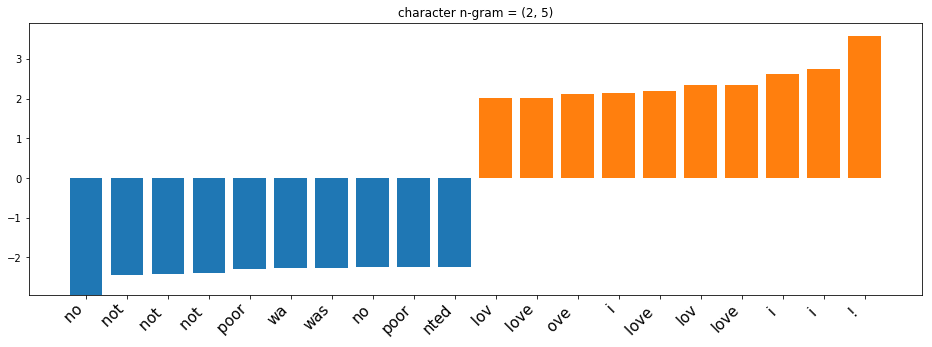

In [46]:
feature_names = np.array(pipeline_tfidf_char_ngram_ranges[6].steps[0][1].get_feature_names())
visualize_feature(pipeline_tfidf_char_ngram_ranges[6].steps[-1][1], feature_names, True, 'character n-gram = (2, 5)')

### 3.3 Investigate how min_df and the use of stop-words changes the number of features when using word n-grams, and how they change the score.

In [52]:
pipeline_tfidf_ngram_range_min_df_stopwords = []
for stop_words in [None, 'english']:
    for min_df in range(1, 6):
        param_grid = {'logisticregression__C': 10 ** (np.random.rand(10) * 4 - 2)}
        pipeline = make_pipeline(TfidfVectorizer(min_df=min_df, ngram_range=(1, 3), stop_words=stop_words), 
                                                   LogisticRegression(), memory='cache_folder')
        pipeline = after_tuning(pipeline, param_grid, X_train, y_train, visual=False)
        pipeline_tfidf_ngram_range_min_df_stopwords.append(pipeline)
        feature_names = np.array(pipeline.steps[0][1].get_feature_names())
        print('stop_words: {}, min_df: {}, shape: {}'.format(stop_words, min_df, len(feature_names)))
        print('-'*80)

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 1.000
best mean roc_auc val score: 0.952
regularization parameter: {'logisticregression__C': 45.3249959252918}
import features:
negative: ['cheap' 'disappointed' 'going back' 'huge' 'not' 'not flattering' 'poor'
 'returned' 'unflattering' 'was']
positive: ['comfortable' 'great' 'little' 'love' 'nice' 'not too' 'perfect' 'soft'
 'unique' 'with']
stop_words: None, min_df: 1, shape: 744765
--------------------------------------------------------------------------------
Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.998
best mean roc_auc val score: 0.952
regularization parameter: {'logisticregression__C': 6.169473987864191}
import features:
negative: ['cheap' 'disappointed' 'huge' 'not' 'not flattering' 'poor' 'returned'
 'to love' 'unflattering' 'was']
positive: ['comfortable' 'great' 'little' 'love' 'love this' 'not too' 'perfect'
 'soft' 'unique' 'with']
s

import features:
negative: ['cheap' 'disappointed' 'huge' 'not' 'not flattering' 'poor' 'returned'
 'to love' 'unflattering' 'was']
positive: ['comfortable' 'great' 'little' 'love' 'love this' 'not too' 'perfect'
 'soft' 'unique' 'with']


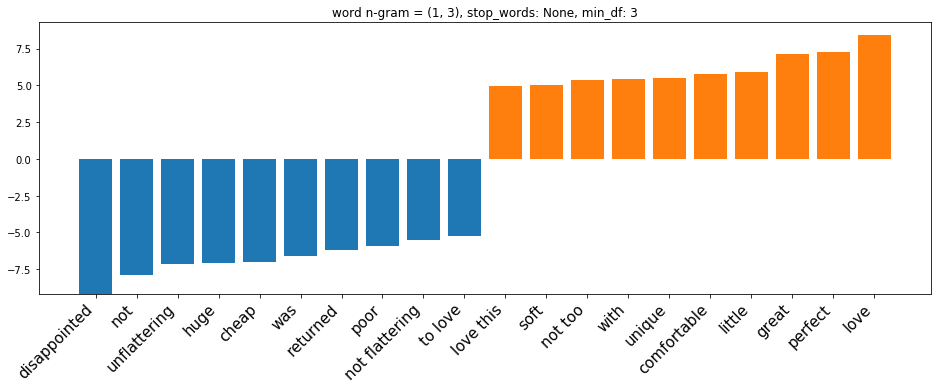

In [60]:
feature_names = np.array(pipeline_tfidf_ngram_range_min_df_stopwords[2].steps[0][1].get_feature_names())
visualize_feature(pipeline_tfidf_ngram_range_min_df_stopwords[2].steps[-1][1],
                  feature_names, True, 'word n-gram = (1, 3), stop_words: None, min_df: 3')

In [61]:
test_score(pipeline_tfidf_ngram_range_min_df_stopwords[2])

roc_auc test score: 0.952


# Task 4 Model Tuning (again)

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.975
best mean roc_auc val score: 0.947
regularization parameter: {'logisticregression__C': 2.8748382036957434}
import features:
negative: ['awful' 'cheap' 'disappointed' 'horrible' 'meh' 'not flattering' 'poor'
 'shame' 'to love' 'unflattering']
positive: ['chic' 'comfortable' 'compliments' 'great' 'love' 'love this' 'my only'
 'not too' 'perfect' 'unique']


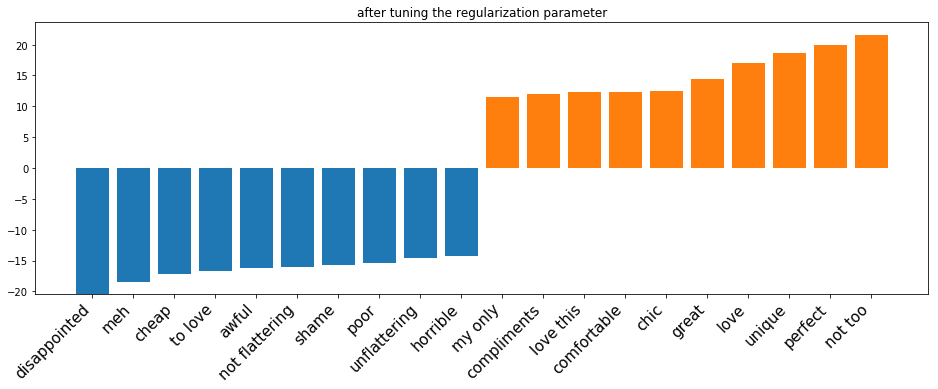

In [62]:
param_grid = {'logisticregression__C': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline = make_pipeline(TfidfVectorizer(min_df=3, ngram_range=(1, 3), stop_words=None), 
                                                   LogisticRegression(penalty='l1'), memory='cache_folder')
pipeline = after_tuning(pipeline, param_grid, X_train, y_train)

In [79]:
pipeline.steps[1][1].coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

Tune the regularization parameter of the classifier......
best mean roc_auc train score: 0.500
best mean roc_auc val score: 0.500
regularization parameter: {'perceptron__alpha': 0.07595828937331837}
import features:
negative: ['00' 'said they run' 'said this' 'said this dress' 'said this is'
 'said this top' 'said to' 'said was' 'said you' 'said you can']
positive: ['has unique' 'has very' 'has very cute' 'has very feminine'
 'has very flattering' 'has very nice' 'has way' 'has way too'
 'has wonderful' 'zoom in you']


/root/assignment2/.env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/root/assignment2/.env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/root/assignment2/.env/lib/python3.5/sit

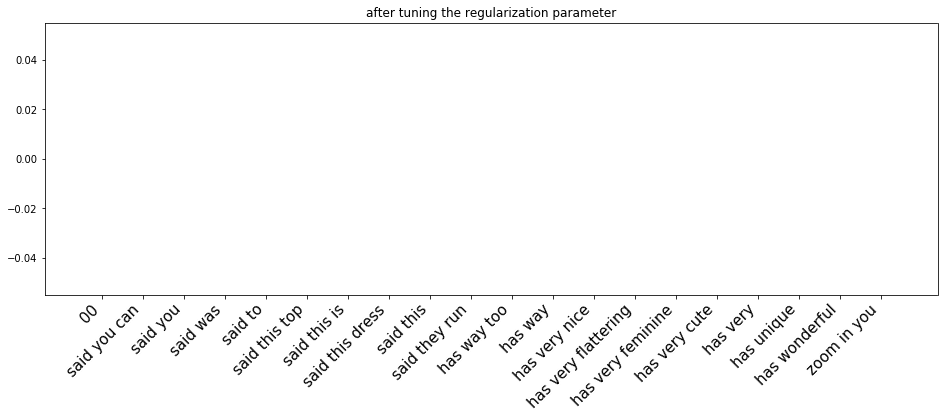

In [75]:
param_grid = {'perceptron__alpha': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline = make_pipeline(TfidfVectorizer(min_df=3, ngram_range=(1, 3), stop_words=None), 
                                                   Perceptron(penalty='l1'), memory='cache_folder')
pipeline = after_tuning(pipeline, param_grid, X_train, y_train)

In [73]:
param_grid = {'perceptron__alpha': 10 ** (np.random.rand(20) * 4 - 2)}
pipeline = make_pipeline(TfidfVectorizer(min_df=3, ngram_range=(1, 3), stop_words=None), 
                                                   Perceptron(penalty='l2'), memory='cache_folder')
pipeline = after_tuning(pipeline, param_grid, X_train, y_train)

Tune the regularization parameter of the classifier......


/root/assignment2/.env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/root/assignment2/.env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/root/assignment

KeyboardInterrupt: 